In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./data/statlog_heart/heart_data.csv")
df.head()

# Taking first 100 rows for simplicity
df = df.iloc[:100]

In [3]:
X = df.drop("heart_disease", axis=1)
Y = df["heart_disease"]

print(X.shape, Y.shape)

(100, 13) (100,)


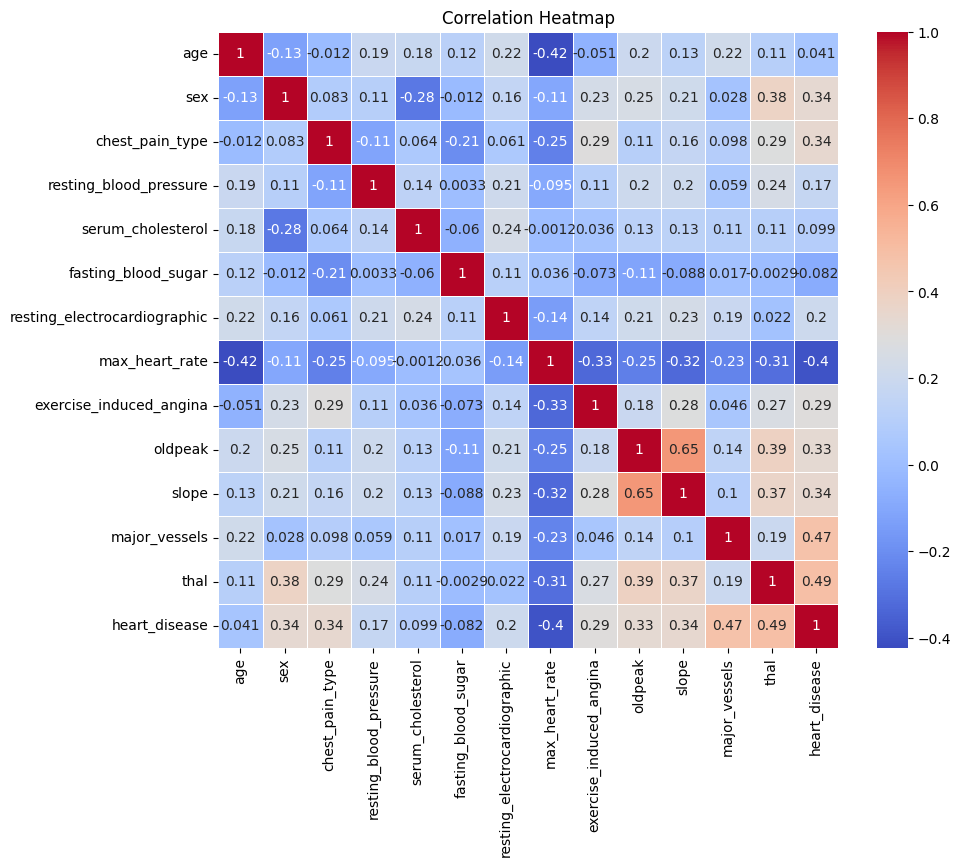

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

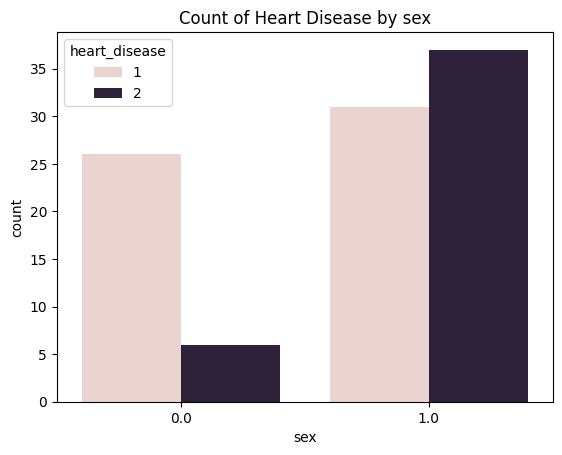

In [5]:
sns.countplot(x='sex', hue='heart_disease', data=df)
plt.title('Count of Heart Disease by sex')
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

# scals between -2pi and 2pi
scaler = MinMaxScaler(feature_range=(-2*np.pi, 2*np.pi))
X = scaler.fit_transform(X)
Y = np.array(Y).reshape(-1, 1) 

In [7]:
from sklearn.model_selection import train_test_split

# split the data into train, validation and test set (70%, 10%, 20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, train_size=0.334, random_state=42)

print("Data: ", X.shape, Y.shape)
print("Train set:", X_train.shape, Y_train.shape)
print("Validation set:", X_valid.shape, Y_valid.shape)
print("Test set:", X_test.shape, Y_test.shape)


Data:  (100, 13) (100, 1)
Train set: (70, 13) (70, 1)
Validation set: (10, 13) (10, 1)
Test set: (20, 13) (20, 1)


### Let the Fun Begin! 

In [8]:
from qiskit.circuit.library import  ZZFeatureMap, PauliFeatureMap
num_features = X.shape[1]

zz_feature_map = ZZFeatureMap(
    feature_dimension=num_features, 
    reps=1
)

# pauli_feature_map = PauliFeatureMap(
#     feature_dimension=num_features, 
#     reps=1, 
#     paulis=['Z', 'XY']
#     entanglement='linear'
# )

pauli_feature_map = PauliFeatureMap(
    feature_dimension=num_features, 
    reps=1, 
    paulis=['Z', 'XY'],
    entanglement='full'
)


# feature_map.decompose().draw(
#     output="mpl",
#     style="clifford",
#     fold=10
# )

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def custom_ansantz(num_qubits):
    theta = ParameterVector("theta", length=num_qubits * 3)
    qc = QuantumCircuit(num_qubits)
    
    # rotations
    for i in range(num_qubits):
        qc.rx(theta[i], i)
        qc.ry(theta[i + num_qubits], i)
        qc.rz(theta[i + 2 * num_qubits], i)
    # entaglement
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    # depth
    for i in range(num_qubits):
        qc.ry(theta[i + 2 * num_qubits], i)
    
    return qc

num_qubits = X.shape[1]
custom_circuit_zz = custom_ansantz(num_qubits)
custom_circuit_pauli = custom_ansantz(num_qubits)
    

In [10]:
from qiskit_algorithms.optimizers import COBYLA 

optimizer = COBYLA(maxiter=20)

In [17]:
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (10, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective Function Value at Step {}".format(len(objective_func_vals)))
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
class EarlyStoppingCallback:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, weights, objective_function_value):
        current_score = objective_function_value

        if self.best_score is None:
            self.best_score = current_score
            self.best_weights = weights.copy()

        elif current_score > self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping: No improvement, counter: {self.counter}')
            
            if self.counter >= self.patience:
                print('EarlyStopping: Triggered')
                self.early_stop = True
        else:
            self.best_score = current_score
            self.best_weights = weights.copy()  
            self.counter = 0

def combined_callback(weights, objective_function_value):
    callback_graph(weights, objective_function_value)

    early_stopping(weights, objective_function_value)

    if early_stopping.early_stop:
        return True  # Returning `True` here should stop optimization

    return False  # Continue training otherwise

early_stopping = EarlyStoppingCallback(patience=5, delta=0.001)


In [18]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc_zz = VQC(
    feature_map=zz_feature_map,
    ansatz=custom_circuit_zz,
    optimizer=optimizer,
    callback=callback_graph,
)



vqc_pauli = VQC(
    feature_map=pauli_feature_map,
    ansatz=custom_circuit_pauli,
    optimizer=optimizer,
    callback=callback_graph,
)

In [20]:
vqc_zz.fit(X_train, Y_train)

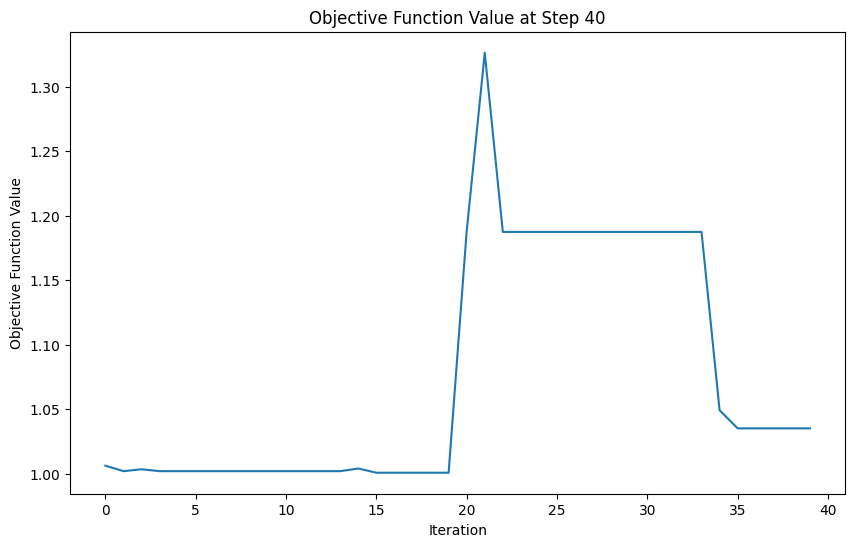

In [15]:
vqc_pauli.fit(X_train, Y_train)


In [16]:
train_score_q2_ra = vqc_zz.score(X_train, Y_train)
test_score_q2_ra = vqc_zz.score(X_test, Y_test)

print(f"Quantum ZZ_VQC Train Score: {train_score_q2_ra:.4f}")
print(f"Quantum ZZ_VQC Test Score: {test_score_q2_ra:.4f}")

# train_score_q2_ra = vqc_pauli.score(X_train, Y_train)
# test_score_q2_ra = vqc_pauli.score(X_test, Y_test)

# print(f"Quantum Pauli_VQC Train Score: {train_score_q2_ra:.4f}")
# print(f"Quantum Pauli_VQC Test Score: {test_score_q2_ra:.4f}")

Quantum ZZ_VQC Train Score: 0.5000
Quantum ZZ_VQC Test Score: 0.4500


### LESS THAN A COIN FLIP !!!!!!!